# Modellere temperaturen på jorden

## Innledning
I denne oppgaven skal jeg forsøke å lage en god (eller hvertfall aksepterbar) modell for temperaturen på jordas overflate.

## Teori
Temperaturen på jorda er en funskjon av utrolig mange parametere. En av de viktigste parameterne er "solkonstanten" (i koden: "radiation_earth"). Denne konstanten beskriver hvor mye energi som overflaten til jorden får av sola, per kvadratmeter, per sekund, på grunn av strålingen fra sola. Enheten er altså $\frac{W}{m^2}$. Det er viktig å merke seg at denne konstanten antar at overflaten står normalt på solstrålene. Solkonstanten kan man finne med denne formelen:
$$ S = \sigma T^4 \frac{r^2}{d^2} $$
der $S$ er solkonstanten, $\sigma = 5.6703*10^{-8}$, $r$ er radiusen til solen og $d$ er distansen mellom jorden og solen

In [87]:
dist = 149_597_870e3
r_sun = 696_340e3
t_sun = 5_778
sigma = 5.6703e-8

def radiation_earth_given_dist(d):
    return sigma * t_sun**4 * r_sun**2 /  d**2

radiation_earth = radiation_earth_given_dist(dist)

print(f'solkonstanten: {radiation_earth} W/m^2')

solkonstanten: 1369.3297797280723 W/m^2


Her kan vi se at solkonstanten er ca. 1369,33 $\frac{W}{m^2}$.

Det er viktig å merke seg at dette kun er en tilnærming som ikke tar for seg at:
- distansen mellom jorda og sola ikke er konstant
- temperaturen til sola ikke er konstant
- solstrålene kan tildekkes av andre astronomiske objekter

Men dersom vi lagde en modell for solkonstanten som tok alle disse endringene inn i betraktning, ville det ikke gjordt en stor forskjell. 1369,33 er altså en ganske god tilnærming, selv om den ikke er perfekt. Så la oss bruke den.

Først vil jeg finne den totale energien (i koden: energy_earth) som blir tilført jorden, av solen, per sekund. Det er så lett som å gange solkonstanten med den totale arealet som jorda ser ut til å ha, fra solen. Og siden jorda ser ut som en 2D sirker fra solas perspektiv, er dette arealet bare $\pi r^2$. Men en andel av den strålingen blir reflektert, og har derfor aldri en effekt på jorda. Derfor ganger jeg til slutt med en konstant albedo som jeg tenker at er $0,7$. Jeg antar altså at $30$% av strålingen blir reflektert

In [120]:
from math import pi

r_earth = 6_371e3
area_earth = pi * r_earth**2

def energy_earth_given_radiation(radiation, albedo=0.7):
    return radiation * area_earth * albedo

energy_earth = energy_earth_given_radiation(radiation_earth)
print(f'den totale energien som treffer jorda, per sekund: {energy_earth} W')

den totale energien som treffer jorda, per sekund: 1.222281324192855e+17 W


Det er liten grunn til å tro at $1,22*10^{17} W$ er et upresist tall, dersom verdien jeg valgte for albedo var perfekt. Problemet er bare at 0,7 er et vilkålig tall jeg valgte med magefølelsen min, og tallet kan ikke støtte seg på vitenskaplige målinger. Derfor er nok dette tallet ganske upresist, men jeg velger å bruke det alikavel.

## La oss finne temperaturen på jorda (endelig!)

La oss tenke oss at jorden varmes opp av sola, fra $0^{\circ}K$. Da ville den fått energi fra sola, samtidig som at den gir fra seg energi i form av sin egen stråling. La oss skrive det mer konkret, med en diff. ligning:
$$
\dot E = S - A \sigma T^4
$$

Her er:
- E: den totale energien på jorda
- S: den totale energien som jorda får av sola
- A: overflatearealet til jorda
- T: temperaturen på jorda
- $\sigma = 5.6703*10^{-8}$

La oss omforme dette så vi finner $\dot T$:
$$
\dot T = \frac{S - A \sigma T^4}{A}
$$

Her antar jeg altså at $T=\frac{E}{A}$, og det kan hende at ikke er presist. Denne antagelsen kommer fra at temperaturen er propesjonal med varme-energien, men omvendt propesjonal med arealet, og at propesjonalitetskonstantene krysser hverandre ut til slutt. At propesjonalitetskonstantene krysser hverandre ut kan virke som en gangske vill antagelse, men vi kommer alikavel til å få gangske gode resultater, som leder meg til å tro at det er riktig.

Videre, vi kan nå bruke Euler's metode for å estimere hva temperaturen til jorda blir etter at solen har varmet den opp en stund, ut ifra denne diff. ligningen.

sluttemperatur: -18.212958017772195 grader C


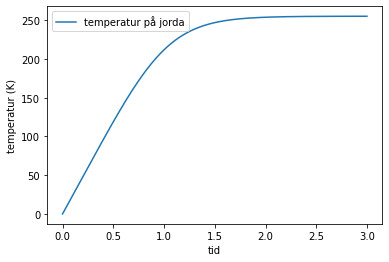

In [129]:
from pylab import *

S = energy_earth
A = surface_earth

t_list = []
T_list = []

def T_dot(T):
    return (S - A * sigma * T**4) / A

dt = 1e-3
t_max = 3
T = 0
for t in arange(0, t_max, dt):
    T += T_dot(T) * dt
    
    t_list.append(t)
    T_list.append(T)

plot(t_list, T_list, label='temperatur på jorda')
legend()
xlabel('tid')
ylabel('temperatur (K)')
T_in_C = T_list[-1] - 273.15
print(f'sluttemperatur: {T_in_C} grader C')

Her kan vi se at temperaturen øker linært fram til jorda blir varm nok til å gi fra seg like mye stråling som den får av sola. Det er her grafen flater seg ut. Og da fikk den en sluttemperatur på ca. $-18,2^{\circ} C$

Men gjennomsnittstemperaturen på jorda er hvertfall ikke -18 grader! Og dette er antagelig på grunn av noen ganske grove antagelser vi har gjordt fram til nå. Diff. ligningen vår antar at:
- jorda er en perfekt sirkel, i perfekt vakum
- jorda ikke har noen atmotsfære
- jorda ikke blir varmet opp av sin egen kjerne

## På tide å modellere en atmotsfære

Så la oss nå forsøke å modellere en atmotsfære. Først vil jeg understreke noen antagelser jeg gjør:
- All stråling fra sola går rett gjennom atmotsfæren
- All stråling fra jorda treffer atmotsfæren
- Halvparten av strålingen fra atmotsfæren treffer jorda
- Atmotsfæren ikke har volum, og har lik areal som jorda

Vi skal gjøre det samme som vi gjorde i modellen før, men nå må vi også holde styr på temperaturen i atmotsfæren og vi får derfor 2 diff. ligninger som sammen forklarer situasjonen. Først, temperaturen i atmotsfæren: Atmotsfæren får energi av strålingen fra jorda, samtidig som at den gir fra stråling. Dette kan representeres av diff. ligningen

$$
\dot E_a = A(\sigma T_j^4 - \sigma T_a^4)
$$
der:
- $E_a$ er varmeenergien i atmotsfæren
- $T_j$ er temperaturen på jorda
- $T_a$ er temperaturen i atmotsfæren
- $A$ er overflatearealet til jorda
- $\sigma = 5.6703*10^{-8}$

La oss omformulere ligningen til å finne $\dot T_a$ ved samme argument som ved forrige gang:

$$
\dot T_a = \sigma T_j^4 - \sigma T_a^4
$$

Nå, la oss finne en diff. ligning for temperaturen på jorda:
- Jorda får energi fra varmestrålingen fra sola
- Jorda får energi fra strålingen til atmotsfæren. Her antar jeg at halvparten av strålingen som atmotsfæren sender ut, treffer jorda, mens resten går til verdensrommet
- Jorda gir fra sin egen varmestråling
Dette kan representeres med følgende diff. ligning:
$$
\dot E_j = S + A 0.5 \sigma T_a^4 - A \sigma T_j^4
$$

La oss omformulere ligningen til å finne $\dot T_j$ ved samme argument som ved forrige gang:

$$
\dot T_j = \frac{S}{A} + 0.5 \sigma T_a^4 - \sigma T_j^4
$$

Videre, vi kan nå (endelig) bruke Euler's metode for å estimere hva temperaturen til jorda og atmotsfæren blir etter at solen har varmet dem opp i en stund.

sluttemperaturen på jorda er 29.752319146825528 grader C


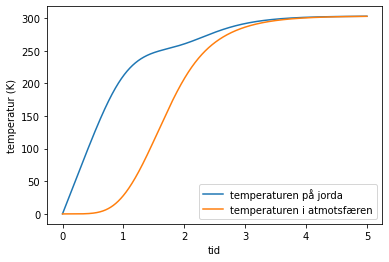

In [133]:
from pylab import *

S = energy_earth_given_radiation(radiation_earth)
A = surface_earth

t_list = []
T_j_list = []
T_a_list = []

def T_j_dot(T_j, T_a):
    return (S / A) + 0.5 * sigma * T_a**4 - sigma * T_j**4

def T_a_dot(T_j, T_a):
    return sigma * T_j**4 - sigma * T_a**4

dt = 1e-3
t_max = 5
T_j = 0
T_a = 0
for t in arange(0, t_max, dt):
    T_j += T_j_dot(T_j, T_a) * dt
    T_a += T_a_dot(T_j, T_a) * dt
    
    t_list.append(t)
    T_j_list.append(T_j)
    T_a_list.append(T_a)

plot(t_list, T_j_list, label='temperaturen på jorda')
plot(t_list, T_a_list, label='temperaturen i atmotsfæren')

legend()
xlabel('tid')
ylabel('temperatur (K)')

T_in_C = T_j_list[-1] - 273.15
print(f'sluttemperaturen på jorda er {T_in_C} grader C')

Her kan vi se at sola varmer opp jorda og atmotsfæren til de etter hvert blir ca. $29,8^{\circ} C$. Dette er ikke nøyaktig lik den måte gjennomsnittstemperaturen som er ca. $15^{\circ} C$, men vi nærmer oss.

Grunnen til at modellen ikke stemmer med virkeligheten er på grunn av noen sentrale antagelser vi har gjordt. Som at all stråling fra sola på jorda ikke samhandler med atmotsfæren på noen som helst måte. Og at temperaturen er lik over hele jorda og atmotsfæren. Og at atmotsfæren ikke har tykkelse. Eller at halvparten av strålingen fra atmotsfæren treffer jorda, mest sansynlig treffer antagelig rundt 30-40 % på grunn av atmotsfærens høyde over overflaten på jorda, og på grunn av refleksjon osv.

15.317459964555667


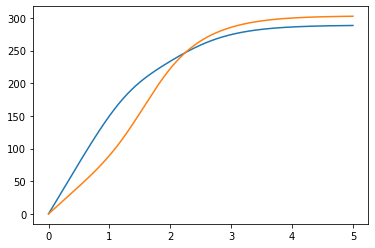

In [118]:
from pylab import *

def temp_earth_given_S(S, should_plot=True):
    A = surface_earth
    alfa = 0.5
    beta = 0.65

    t_list = []
    T_j_list = []
    T_a_list = []

    def T_j_der(T_j, T_a):
        return (S / A) * beta + alfa * sigma * T_a**4 - sigma * T_j**4

    def T_a_der(T_j, T_a):
        return (S / A) * (1 - beta) + sigma * T_j**4 - sigma * T_a**4

    dt = 1e-3
    t_max = 5
    T_j = 0
    T_a = 0
    for t in arange(0, t_max, dt):
        T_j += T_j_der(T_j, T_a) * dt
        T_a += T_a_der(T_j, T_a) * dt

        t_list.append(t)
        T_j_list.append(T_j)
        T_a_list.append(T_a)

    if (should_plot):
        plot(t_list, T_j_list)
        plot(t_list, T_a_list)
    return T_j_list[-1]

S = energy_earth_given_radiation(radiation_earth)
print(temp_earth_given_S(S) - 273.15)

Temperaturen i Norge i løpet av et år 🦄: min: -24.475815633430074, max: 11.512715688091589


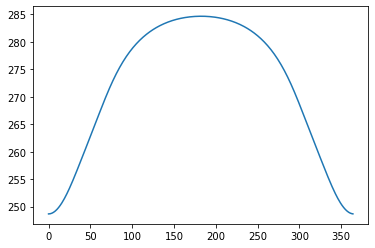

In [119]:
from math import sin

temps = []
year = range(365)

ap = 152_098_233e3
per = 147_098_291e3
a = (ap + per) / 2
diff = ap - a

latitude = 59.8562209 * pi / 180
earth_tilt = 23.5 * pi / 180

avg_radiation = radiation_earth_given_dist(149_597_870e3)
avg_S = energy_earth_given_radiation(avg_radiation)
avg_temp = temp_earth_given_S(avg_S, should_plot=False)

gamma = 0.8

for day in year:
    theta = 2 * pi * day / len(year)
    dist = - diff * cos(theta) + a
    radiation = radiation_earth_given_dist(dist)
    n_lat = earth_tilt * cos(theta) + latitude
    cos_lat = cos(n_lat)
    S = cos_lat * energy_earth_given_radiation(radiation)
    temperature_norway = temp_earth_given_S(S, should_plot=False)
    temperature_norway = temperature_norway * (1 - gamma) + avg_temp * gamma
    temps.append(temperature_norway)

plot(year, temps)

min_temp = min(temps) - 273.15
max_temp = max(temps) - 273.15
print(f'Temperaturen i Norge i løpet av et år 🦄: min: {min_temp}, max: {max_temp}')